In [1]:
import pandas as pd
import numpy as np

In [2]:
orderlines_qu = pd.read_csv("orderlines_qu.csv")
products_qu = pd.read_csv("products_qu.csv")
orders_qu = pd.read_csv("orders_qu.csv")

In [3]:
orderlines_qu_cp = orderlines_qu.copy()
orders_qu_cp = orders_qu.copy()
products_qu_cp = products_qu.copy() 

In [4]:
#Changing the date column to datetime type
orderlines_qu_cp['date'] = pd.to_datetime(orderlines_qu_cp['date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
orders_qu_cp['created_date'] = pd.to_datetime(orders_qu_cp['created_date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [6]:
orderlines_qu_cp.head()

,id,order_id,product_quantity,sku,unit_price,date,man
0,1119116,299545,1,OWC0100,47.49,2017-01-01 01:46:16,OWC
1,1119119,299546,1,IOT0014,18.99,2017-01-01 01:50:34,IOT
2,1119120,295347,1,APP0700,72.19,2017-01-01 01:54:11,APP
3,1119134,299556,1,CRU0039-A,60.90,2017-01-01 02:20:14,CRU
4,1119145,299561,1,PEB0015,142.49,2017-01-01 02:38:50,PEB


In [7]:
orderlines_qu_cp = orderlines_qu_cp.rename(columns = {"id_order" : "order_id"})

In [8]:
merged_orders = orders_qu_cp.merge(orderlines_qu_cp, on ='order_id').merge(products_qu_cp, how='left', on='sku')

In [13]:
#we dont need all the columns
merged_orders_short = merged_orders.drop(columns = ['id', 'state',"name","desc","man_x","in_stock","type"]).copy()

In [14]:
merged_orders_short

,order_id,created_date,total_paid,product_quantity,sku,unit_price,date,price,man_y
0,241423,2017-11-06 13:10:02,136.15,1,LAC0212,129.16,2017-11-06 12:47:20,139.99,LAC
1,242832,2017-12-31 17:40:03,15.76,1,PAR0074,10.77,2017-12-31 17:26:40,17.99,PAR
2,243330,2017-02-16 10:59:38,84.98,1,OWC0074,77.99,2017-02-15 17:07:44,99.99,OWC
3,245275,2017-06-28 11:35:37,149.00,1,TAD0007,149.00,2017-06-28 11:12:30,179.00,TAD
4,245595,2017-01-21 12:52:47,112.97,2,PAC1561,52.99,2017-01-21 12:49:00,103.95,PAC
...,...,...,...,...,...,...,...,...,...
53210,527042,2018-03-14 11:47:50,18.98,1,APP0927,13.99,2018-03-14 11:42:38,35.00,APP
53211,527070,2018-03-14 11:50:48,24.97,2,APP0698,9.99,2018-03-14 11:49:01,25.00,APP
53212,527074,2018-03-14 11:51:42,24.97,2,APP0698,9.99,2018-03-14 11:49:36,25.00,APP
53213,527096,2018-03-14 11:58:40,34.96,3,APP0698,9.99,2018-03-14 11:54:35,25.00,APP


In [15]:
merged_orders_short['item_price_total'] = merged_orders_short["unit_price"] * merged_orders_short['product_quantity'] 

In [16]:
#Calculating the discount
merged_orders_short['discount'] = merged_orders_short['price'] - merged_orders_short['unit_price']

In [17]:
#Calculating discount percentage
merged_orders_short["discount_perc"] =round((merged_orders_short["discount"]/merged_orders_short['price']) * 100, 2)

In [18]:
merged_orders_short["discount_perc"].describe()

count    53215.000000
mean        21.383857
std         18.143281
min       -212.270000
25%          9.090000
50%         17.660000
75%         28.590000
max         97.140000
Name: discount_perc, dtype: float64

In [19]:
minus_discounts = merged_orders_short.loc[merged_orders_short.discount_perc < 0,].sort_values(by = 'discount_perc')

In [21]:
#we could group the discount to see how many values are there , but this results in a huge amount of categories
minus_discounts.groupby('discount_perc')['order_id'].count().sort_values(ascending=False)

discount_perc
-0.10     122
-0.16     114
-0.04      92
-0.20      90
-0.27      66
         ... 
-27.88      1
-9.97       1
-10.20      1
-3.82       1
-23.64      1
Name: order_id, Length: 328, dtype: int64

In [33]:
minus_discounts['discount_perc'].value_counts()

discount_perc
-0.10     122
-0.16     114
-0.04      92
-0.20      90
-0.27      66
         ... 
-27.88      1
-9.97       1
-10.20      1
-3.82       1
-23.64      1
Name: count, Length: 328, dtype: int64

In [22]:
# you could create a second column where you create groups for the discounts to have a clearer viw
minus_discounts["interval"] = ""
minus_discounts.loc[minus_discounts.discount_perc > -1, "interval" ] = "below 1"

In [25]:
# Creating a new column 'interval' to categorize negative discount values to have a clearer wiev
minus_discounts["interval"] = ""

# Categorizing discount values into groups
minus_discounts.loc[minus_discounts.discount_perc > -1, "interval"] = "Near Zero"
minus_discounts.loc[(minus_discounts.discount_perc <= -1) & (minus_discounts.discount_perc > -5), "interval"] = "Small"
minus_discounts.loc[(minus_discounts.discount_perc <= -5) & (minus_discounts.discount_perc > -20), "interval"] = "Medium"
minus_discounts.loc[(minus_discounts.discount_perc <= -20) & (minus_discounts.discount_perc > -50), "interval"] = "Large"
minus_discounts.loc[(minus_discounts.discount_perc <= -50) & (minus_discounts.discount_perc > -100), "interval"] = "Very Large"
minus_discounts.loc[minus_discounts.discount_perc <= -100 , "interval"] = "Extreme"

In [32]:
interval_counts = minus_discounts["interval"].value_counts()
interval_counts

interval
Near Zero     823
Medium        397
Small         198
Large         137
Very Large      7
Extreme         3
Name: count, dtype: int64

In [ ]:
# Rounding near zero discounts to zero
#merged_orders_short.loc[(merged_orders_short["discount_perc"] < 0) & (merged_orders_short["discount_perc"] > -1), "discount_perc"] = 0

# Removing extreme values
#merged_orders_short = merged_orders_short[~(merged_orders_short["discount_perc"] <= -100)]


In [34]:
# what is the time period that dataset covers?
earliest_date = merged_orders_short['date'].min()
latest_date = merged_orders_short['date'].max()

print(latest_date-earliest_date)

437 days 10:11:57


In [35]:
# What is the overall revenue for that time?
total_revenue = merged_orders_short['total_paid'].sum()
print(f"Total revenue in the timeframe: {total_revenue.round(2)}")

Total revenue in the timeframe: 11792843.51


In [38]:
#Are there seasonal patterns in the evolution of sales?
merged_orders_short["month"] = merged_orders_short['date'].dt.month
merged_orders_short["year"] = merged_orders_short['date'].dt.year


In [39]:
merged_orders_short

,order_id,created_date,total_paid,product_quantity,sku,unit_price,date,price,man_y,item_price_total,discount,discount_perc,month,year
0,241423,2017-11-06 13:10:02,136.15,1,LAC0212,129.16,2017-11-06 12:47:20,139.99,LAC,129.16,10.83,7.74,11,2017
1,242832,2017-12-31 17:40:03,15.76,1,PAR0074,10.77,2017-12-31 17:26:40,17.99,PAR,10.77,7.22,40.13,12,2017
2,243330,2017-02-16 10:59:38,84.98,1,OWC0074,77.99,2017-02-15 17:07:44,99.99,OWC,77.99,22.00,22.00,2,2017
3,245275,2017-06-28 11:35:37,149.00,1,TAD0007,149.00,2017-06-28 11:12:30,179.00,TAD,149.00,30.00,16.76,6,2017
4,245595,2017-01-21 12:52:47,112.97,2,PAC1561,52.99,2017-01-21 12:49:00,103.95,PAC,105.98,50.96,49.02,1,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53210,527042,2018-03-14 11:47:50,18.98,1,APP0927,13.99,2018-03-14 11:42:38,35.00,APP,13.99,21.01,60.03,3,2018
53211,527070,2018-03-14 11:50:48,24.97,2,APP0698,9.99,2018-03-14 11:49:01,25.00,APP,19.98,15.01,60.04,3,2018
53212,527074,2018-03-14 11:51:42,24.97,2,APP0698,9.99,2018-03-14 11:49:36,25.00,APP,19.98,15.01,60.04,3,2018
53213,527096,2018-03-14 11:58:40,34.96,3,APP0698,9.99,2018-03-14 11:54:35,25.00,APP,29.97,15.01,60.04,3,2018


In [41]:
#aggregate total paid by month
monthly_sales = merged_orders_short.groupby(["year", "month"])["total_paid"].sum().reset_index()
monthly_sales

,year,month,total_paid
0,2017,1,972794.59
1,2017,2,492159.94
2,2017,3,38270.48
3,2017,4,343511.69
4,2017,5,486260.34
5,2017,6,442097.36
6,2017,7,903580.87
7,2017,8,544592.31
8,2017,9,597060.60
9,2017,10,823673.41


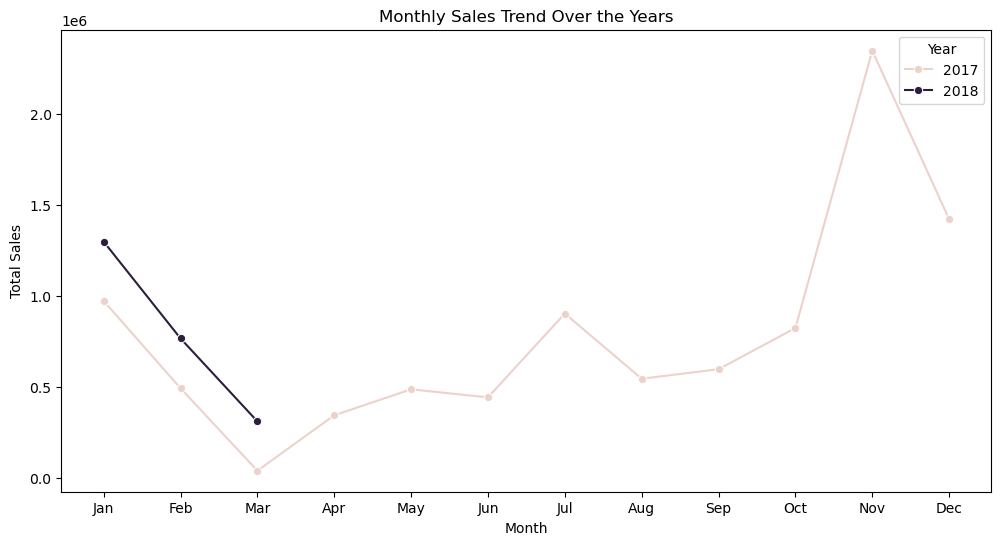

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x="month", y="total_paid", hue="year", marker="o")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.title("Monthly Sales Trend Over the Years")
plt.legend(title="Year")
plt.show()


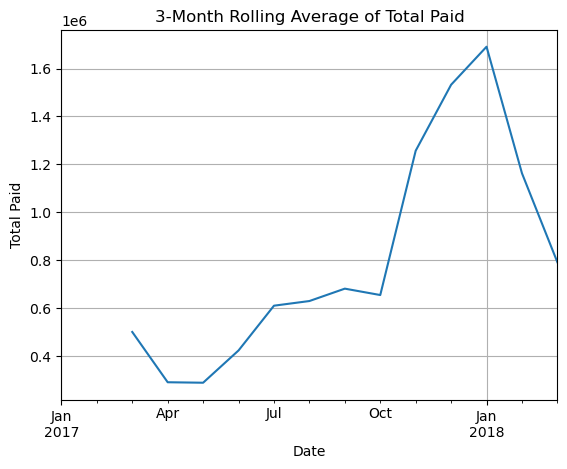

In [45]:
#3 month rolling average (moving average)
#smooths out short-term fluctuations by averaging sales over the past 3 months. 
#It helps to identify trends by reducing noise in the data.

monthly_sales.rolling(3).mean().plot(title="3-Month Rolling Average of Total Paid")
plt.ylabel("Total Paid")
plt.xlabel("Date")
plt.grid()
plt.show()



Autocorrelation - Peak at LAG 12
Consistency: While the peak isn’t very sharp, it still suggests a consistent but subtle seasonal trend. This could mean that your sales behavior is influenced by yearly events, such as holidays, promotions, or seasonal products.

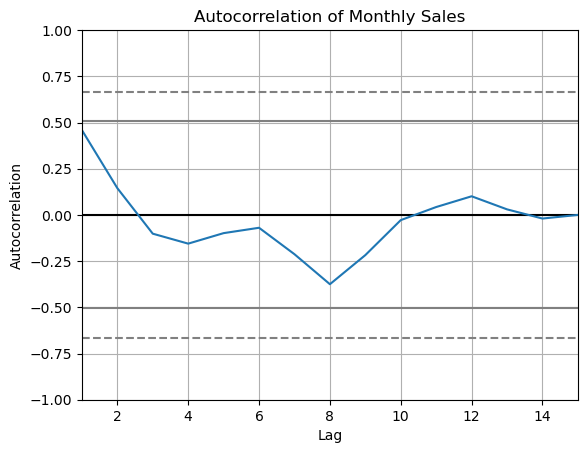

In [47]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(monthly_sales)
plt.title("Autocorrelation of Monthly Sales")
plt.show()
